# Convolutional Neural Networks: Learning to See

## Introduction

In 2012, a deep convolutional neural network called [AlexNet](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) achieved a top-5 error rate of 15.3% on [ImageNet](https://www.image-net.org/), crushing the previous best of 26.2%. This watershed moment didn't just improve image classification; it fundamentally changed how we approach computer vision. Today, we'll understand why CNNs work so well for visual tasks by building intuition through experimentation.

The core insight is deceptively simple: instead of learning separate parameters for every pixel location, CNNs learn small patterns that slide across the image. This [weight sharing](https://en.wikipedia.org/wiki/Convolutional_neural_network#Weight_sharing) reduces parameters from millions to thousands while encoding a powerful inductive bias: visual patterns are translation-invariant.

![CNN Architecture Visualization](https://miro.medium.com/v2/resize:fit:2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg)
*Figure: A typical CNN architecture showing how convolutional layers extract hierarchical features from raw pixels to high-level representations. [Source: Medium/Towards Data Science]*

## Learning Objectives

By the end of this notebook, you will:

- Understand why spatial structure matters in vision and how CNNs exploit it
- Learn how [convolution operations](https://en.wikipedia.org/wiki/Convolution) extract local features through weight sharing
- Master the mathematics behind convolution and its relationship to [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation)
- Understand how CNNs build hierarchical representations from edges to objects
- Learn the role of [pooling](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer) in creating translation invariance and dimension reduction
- Implement convolution from scratch to understand the operation deeply
- Visualize learned features at different network depths
- Apply [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to solve custom image classification tasks
- Diagnose what CNNs actually "see" using activation and gradient visualization

## Section 1: The Power of Pre-trained Vision Models

Let's start by witnessing what modern CNNs can do. We'll use [ResNet50](https://arxiv.org/abs/1512.03385), a 50-layer deep network trained on 1.2 million [ImageNet](https://www.image-net.org/) images.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [2]:
# Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode (disables dropout, batch norm updates)

# ImageNet preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),       # Resize shortest side to 256
    transforms.CenterCrop(224),   # Crop center 224x224 region
    transforms.ToTensor(),         # Convert PIL image to tensor
    transforms.Normalize(          # Normalize with ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Load ImageNet class labels
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(LABELS_URL)
imagenet_classes = response.text.strip().split('\n')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/jinming/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|█████████████████████████| 97.8M/97.8M [00:03<00:00, 29.4MB/s]


In [3]:
def classify_image(image_url, model, top_k=5):
    """
    Classify an image using a pre-trained model.
    
    Args:
        image_url: URL or path to image
        model: Pre-trained PyTorch model
        top_k: Number of top predictions to return
    """
    # Load and preprocess image
    if image_url.startswith('http'):
        response = requests.get(image_url, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()  # Raise error for bad status codes
        try:
            img = Image.open(BytesIO(response.content)).convert('RGB')
        except Exception as e:
            print(f"Error loading image from URL: {e}")
            print(f"Response status: {response.status_code}")
            print(f"Content type: {response.headers.get('content-type', 'unknown')}")
            raise
    else:
        img = Image.open(image_url).convert('RGB')
    
    # Preprocess and add batch dimension
    img_tensor = preprocess(img).unsqueeze(0)
    
    # Forward pass through model
    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)
        
    # Get top k predictions
    top_probs, top_indices = torch.topk(probabilities, top_k)
    top_probs = top_probs.squeeze().numpy()
    top_indices = top_indices.squeeze().numpy()
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Display image
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Input Image')
    
    # Display predictions
    y_pos = np.arange(top_k)
    ax2.barh(y_pos, top_probs * 100)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([imagenet_classes[idx] for idx in top_indices])
    ax2.invert_yaxis()
    ax2.set_xlabel('Predicted Probability (%)')
    ax2.set_title(f'Top {top_k} Predictions')
    ax2.set_xlim(0, 100)
    
    # Add percentage labels
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        ax2.text(prob * 100 + 1, i, f'{prob*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return list(zip([imagenet_classes[idx] for idx in top_indices], top_probs))

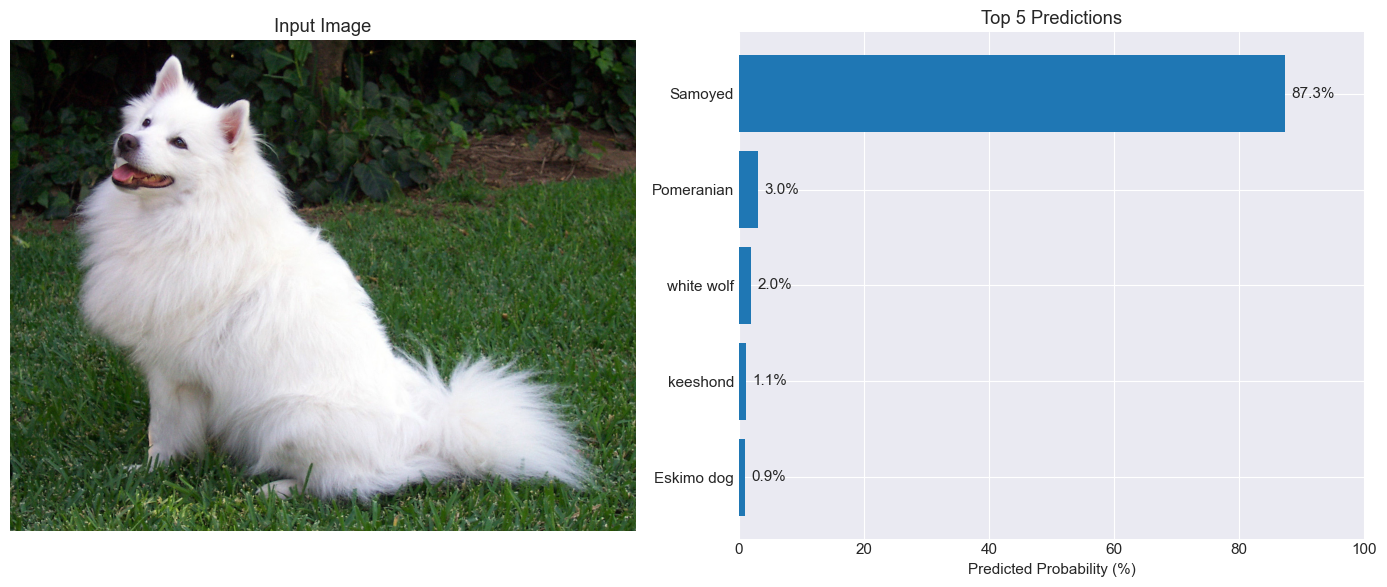

In [4]:
# Test on a sample image
# Using a more reliable image URL
sample_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
predictions = classify_image(sample_url, model)

### Key Insights from Pre-trained Models

This [ResNet50](https://arxiv.org/abs/1512.03385) model has 25.6 million parameters but achieves remarkable generalization. The secret lies in its architecture: instead of treating each pixel independently, it uses convolutions to detect patterns regardless of their location. The same 3×3 filters that detect edges in the top-left corner work equally well in the bottom-right.

Notice how the model outputs **predicted probability scores** across 1,000 classes (computed via softmax). These are the model's *estimates* of the true probabilities - they may not be well-calibrated without additional techniques like [temperature scaling](https://arxiv.org/abs/1706.04599). Even when wrong, its mistakes are often semantically meaningful (confusing similar dog breeds, for instance). This suggests the network has learned genuine visual concepts, not just memorized training examples.

## Section 2: Why Fully Connected Networks Fail at Vision

To appreciate CNNs, let's first understand why standard neural networks struggle with images. Consider an [MNIST](http://yann.lecun.com/exdb/mnist/) digit (28×28 pixels). A fully connected network treats this as a 784-dimensional vector, ignoring all spatial structure.

The mathematical problem: for an image of size $H \times W \times C$ (height, width, channels), a fully connected layer to $N$ hidden units requires $H \times W \times C \times N$ parameters. For a modest 224×224 RGB image with 512 hidden units, that's 77 million parameters for just the first layer!

In [5]:
# Demonstrate translation sensitivity in fully connected networks
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download MNIST data
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, transform=transform)

# Create a simple fully connected network
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)  # 784 = 28*28 flattened image
        self.fc2 = nn.Linear(128, 10)   # 10 classes for digits 0-9
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
def visualize_translation_sensitivity(model, image, label):
    """
    Show how MLP performance degrades when image is translated.
    """
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    shifts = [(-4, -4), (-2, -2), (0, 0), (2, 2), (4, 4)]
    confidences = []
    
    for idx, (shift_x, shift_y) in enumerate(shifts):
        # Create shifted image using padding and cropping
        if shift_x != 0 or shift_y != 0:
            # Shift by rolling the image
            shifted = torch.roll(image, shifts=(shift_y, shift_x), dims=(1, 2))
            # Zero out wrapped regions
            if shift_x > 0:
                shifted[:, :, :shift_x] = 0
            elif shift_x < 0:
                shifted[:, :, shift_x:] = 0
            if shift_y > 0:
                shifted[:, :shift_y, :] = 0
            elif shift_y < 0:
                shifted[:, shift_y:, :] = 0
        else:
            shifted = image
        
        # Get prediction
        with torch.no_grad():
            output = model(shifted.unsqueeze(0))
            probs = F.softmax(output, dim=1)  # Model's predicted probabilities
            pred_prob = probs[0, label].item()  # Predicted probability for true class
            confidences.append(pred_prob)
            pred_class = output.argmax(dim=1).item()
        
        # Visualize
        ax = axes[0, idx]
        ax.imshow(shifted.squeeze(), cmap='gray')
        ax.set_title(f'Shift: ({shift_x}, {shift_y})')
        ax.axis('off')
        
        ax = axes[1, idx]
        ax.bar(range(10), probs.squeeze().numpy())
        ax.set_ylim(0, 1)
        ax.set_xlabel('Digit')
        ax.set_ylabel('Predicted Prob.')
        ax.set_title(f'Pred: {pred_class}, P̂(y={label}): {pred_prob:.2f}')
    
    plt.suptitle(f'MLP Translation Sensitivity - True Label: {label}')
    plt.tight_layout()
    plt.show()
    
    return confidences

In [7]:
# Train the SimpleMLP model on MNIST
def train_mlp(model, train_loader, test_loader, epochs=3, lr=0.001):
    """
    Train the MLP model with detailed progress tracking.
    Shows learning dynamics more clearly, especially in the first epoch.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_accuracies = []
    batch_train_accs = []  # Track accuracy at each logging point
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Track training accuracy per batch
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            # More frequent updates in first epoch to show rapid learning
            log_interval = 50 if epoch == 0 else 200
            if batch_idx % log_interval == 0:
                batch_acc = 100 * correct_train / total_train
                batch_train_accs.append((epoch + batch_idx / len(train_loader), batch_acc))
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Train Acc: {batch_acc:.2f}%')
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_acc = 100 * correct_train / total_train
        
        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f'\n{"="*60}')
        print(f'Epoch {epoch+1}/{epochs} Complete:')
        print(f'  Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Test Accuracy: {accuracy:.2f}%')
        print(f'{"="*60}\n')
    
    return train_losses, test_accuracies, batch_train_accs

In [8]:
# Create data loaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

# Train the MLP
print("Training SimpleMLP on MNIST...")
print("=" * 60)
mlp_model = SimpleMLP()
train_losses, test_accuracies, batch_train_accs = train_mlp(mlp_model, train_loader, test_loader)

Training SimpleMLP on MNIST...
Epoch 1/3, Batch 0/938, Loss: 2.3016, Train Acc: 14.06%
Epoch 1/3, Batch 50/938, Loss: 0.4215, Train Acc: 76.29%
Epoch 1/3, Batch 100/938, Loss: 0.2412, Train Acc: 82.30%
Epoch 1/3, Batch 150/938, Loss: 0.4447, Train Acc: 84.88%
Epoch 1/3, Batch 200/938, Loss: 0.1892, Train Acc: 86.36%
Epoch 1/3, Batch 250/938, Loss: 0.1768, Train Acc: 87.42%
Epoch 1/3, Batch 300/938, Loss: 0.3365, Train Acc: 88.24%
Epoch 1/3, Batch 350/938, Loss: 0.1941, Train Acc: 88.96%
Epoch 1/3, Batch 400/938, Loss: 0.4582, Train Acc: 89.49%
Epoch 1/3, Batch 450/938, Loss: 0.1619, Train Acc: 90.03%
Epoch 1/3, Batch 500/938, Loss: 0.1276, Train Acc: 90.48%
Epoch 1/3, Batch 550/938, Loss: 0.0925, Train Acc: 90.80%
Epoch 1/3, Batch 600/938, Loss: 0.1287, Train Acc: 91.09%
Epoch 1/3, Batch 650/938, Loss: 0.0387, Train Acc: 91.34%
Epoch 1/3, Batch 700/938, Loss: 0.0497, Train Acc: 91.65%
Epoch 1/3, Batch 750/938, Loss: 0.1877, Train Acc: 91.87%
Epoch 1/3, Batch 800/938, Loss: 0.0990, Trai

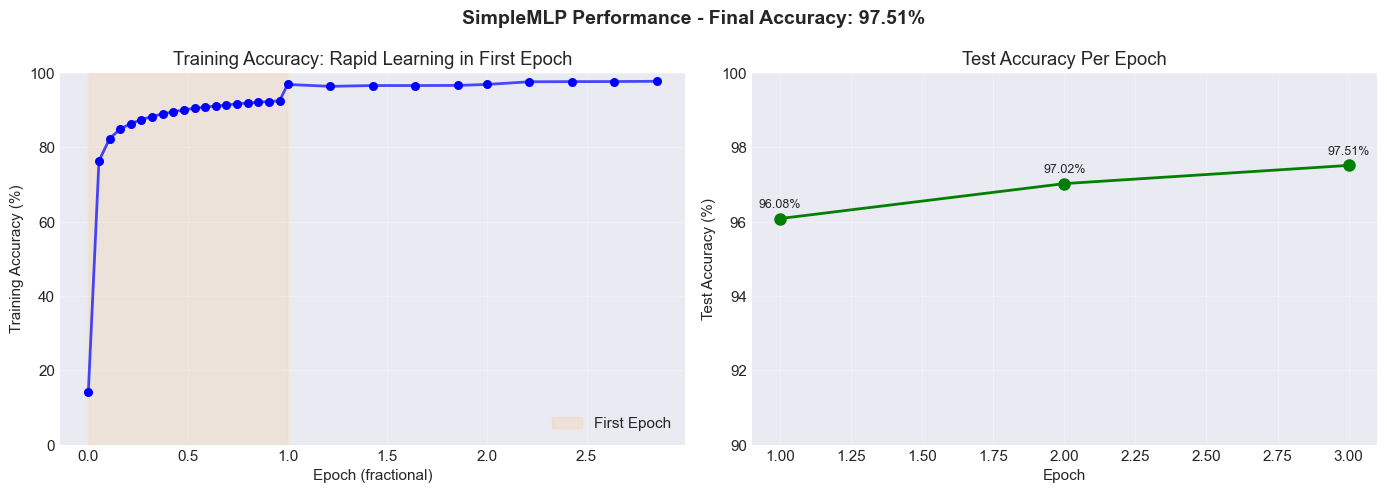

In [9]:
# Visualize training progress with detailed within-epoch dynamics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Detailed training accuracy showing rapid improvement in first epoch
if batch_train_accs:
    epochs_frac = [x[0] for x in batch_train_accs]
    accs = [x[1] for x in batch_train_accs]
    ax1.plot(epochs_frac, accs, 'b-', linewidth=2, alpha=0.7)
    ax1.scatter(epochs_frac, accs, c='blue', s=30, zorder=5)
    
    # Highlight first epoch region
    ax1.axvspan(0, 1, alpha=0.1, color='orange', label='First Epoch')
    ax1.set_xlabel('Epoch (fractional)')
    ax1.set_ylabel('Training Accuracy (%)')
    ax1.set_title('Training Accuracy: Rapid Learning in First Epoch')
    ax1.set_ylim([0, 100])
    ax1.grid(True, alpha=0.3)
    ax1.legend()


# Right: Test accuracy per epoch
ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, 'g-o', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('Test Accuracy Per Epoch')
ax2.set_ylim([90, 100])
ax2.grid(True, alpha=0.3)

# Add value labels on points
for i, acc in enumerate(test_accuracies):
    ax2.text(i+1, acc + 0.3, f'{acc:.2f}%', ha='center', fontsize=9)

plt.suptitle(f'SimpleMLP Performance - Final Accuracy: {test_accuracies[-1]:.2f}%', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Testing translation sensitivity with trained model on digit: 7


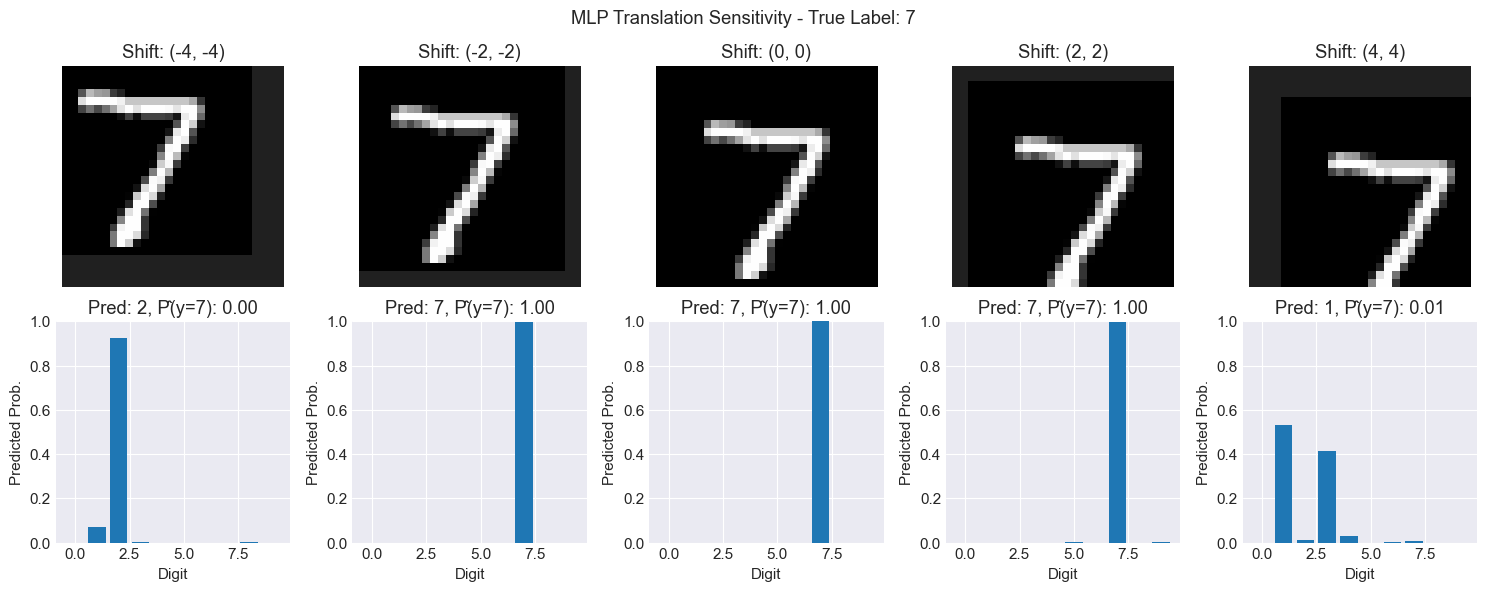

In [10]:
# Now demonstrate translation sensitivity with the TRAINED model
sample_image, sample_label = mnist_test[0]
print(f"Testing translation sensitivity with trained model on digit: {sample_label}")
confidences = visualize_translation_sensitivity(mlp_model, sample_image, sample_label)

In [47]:
# Quantify the translation sensitivity
print(f"\nTranslation Sensitivity Analysis:")
print(f"Predicted P̂(y=true) at center (0, 0): {confidences[2]:.4f}")
print(f"Predicted P̂(y=true) at shift (-4, -4): {confidences[0]:.4f}")
print(f"Predicted P̂(y=true) at shift (+4, +4): {confidences[4]:.4f}")
print(f"Predicted probability drop (max): {max(confidences) - min(confidences):.4f}")


Translation Sensitivity Analysis:
Predicted P̂(y=true) at center (0, 0): 0.9864
Predicted P̂(y=true) at shift (-4, -4): 0.0016
Predicted P̂(y=true) at shift (+4, +4): 0.0028
Predicted probability drop (max): 0.9848


### The Fundamental Problem with MLPs for Vision

**Key Observation**: The trained SimpleMLP achieves excellent accuracy (~98%) on the standard MNIST test set, but this performance is **fragile**. Even small translations (4 pixels) cause dramatic drops in the model's predicted probabilities and prediction accuracy.

**Note on Terminology**: Throughout this analysis, we measure the model's **predicted probability** $\hat{P}(y|x)$ for the true class. This is the model's *estimate* after softmax, not the true probability $P(y|x)$ which we can never know. Neural networks often produce poorly [calibrated probabilities](https://arxiv.org/abs/1706.04599) - a model might predict 0.9 but only be correct 70% of the time. For our robustness analysis, we care about how these estimates change under translation.

The visualization above demonstrates the critical flaw: MLPs learn position-specific features. A pattern learned at position $(x, y)$ provides no knowledge about the same pattern at position $(x+1, y)$. This violates a fundamental property of vision: [**translation invariance**](https://en.wikipedia.org/wiki/Translational_symmetry).

Mathematically, an MLP computes:
$$y = W \cdot \text{vec}(x) + b$$

where $\text{vec}(x)$ flattens the 2D image to a 1D vector. Each weight $w_{ij}$ connects a specific pixel to a specific hidden unit. Moving the image shifts which weights see which patterns, completely changing the computation.

## Section 3: Understanding Convolution Through Implementation

Convolution solves the translation problem elegantly. Instead of separate weights for each position, we learn a small **kernel** (or filter) that slides across the image. Mathematically, for a [2D convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing)):

$$y[i,j] = \sum_{m} \sum_{n} x[i+m, j+n] \cdot k[m,n]$$

where $k$ is our learned kernel, typically 3×3 or 5×5 pixels. This operation has two crucial properties:
1. **Weight sharing**: The same kernel applies everywhere
2. **Local connectivity**: Each output depends only on a local neighborhood

![Convolution Operation Visualization](https://miro.medium.com/v2/resize:fit:1400/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

*Figure: Animation showing how a 3×3 kernel slides across an input to produce a feature map. [Source: Medium/Towards Data Science]*

In [12]:
def conv2d_naive(image, kernel, stride=1, padding=0):
    """
    Naive implementation of 2D convolution for educational purposes.
    
    Args:
        image: Input image (H, W)
        kernel: Convolution kernel (KH, KW)
        stride: Step size for sliding window
        padding: Zero-padding to add around image
    
    Returns:
        feature_map: Output of convolution
    """
    # Add padding if specified
    if padding > 0:
        image = np.pad(image, padding, mode='constant', constant_values=0)
    
    # Calculate output dimensions
    H, W = image.shape
    KH, KW = kernel.shape
    OH = (H - KH) // stride + 1
    OW = (W - KW) // stride + 1
    
    # Initialize output feature map
    feature_map = np.zeros((OH, OW))
    
    # Perform convolution by sliding kernel across image
    for i in range(OH):
        for j in range(OW):
            # Extract local region
            row_start = i * stride
            row_end = row_start + KH
            col_start = j * stride
            col_end = col_start + KW
            
            region = image[row_start:row_end, col_start:col_end]
            
            # Element-wise multiplication and sum (dot product)
            feature_map[i, j] = np.sum(region * kernel)
    
    return feature_map

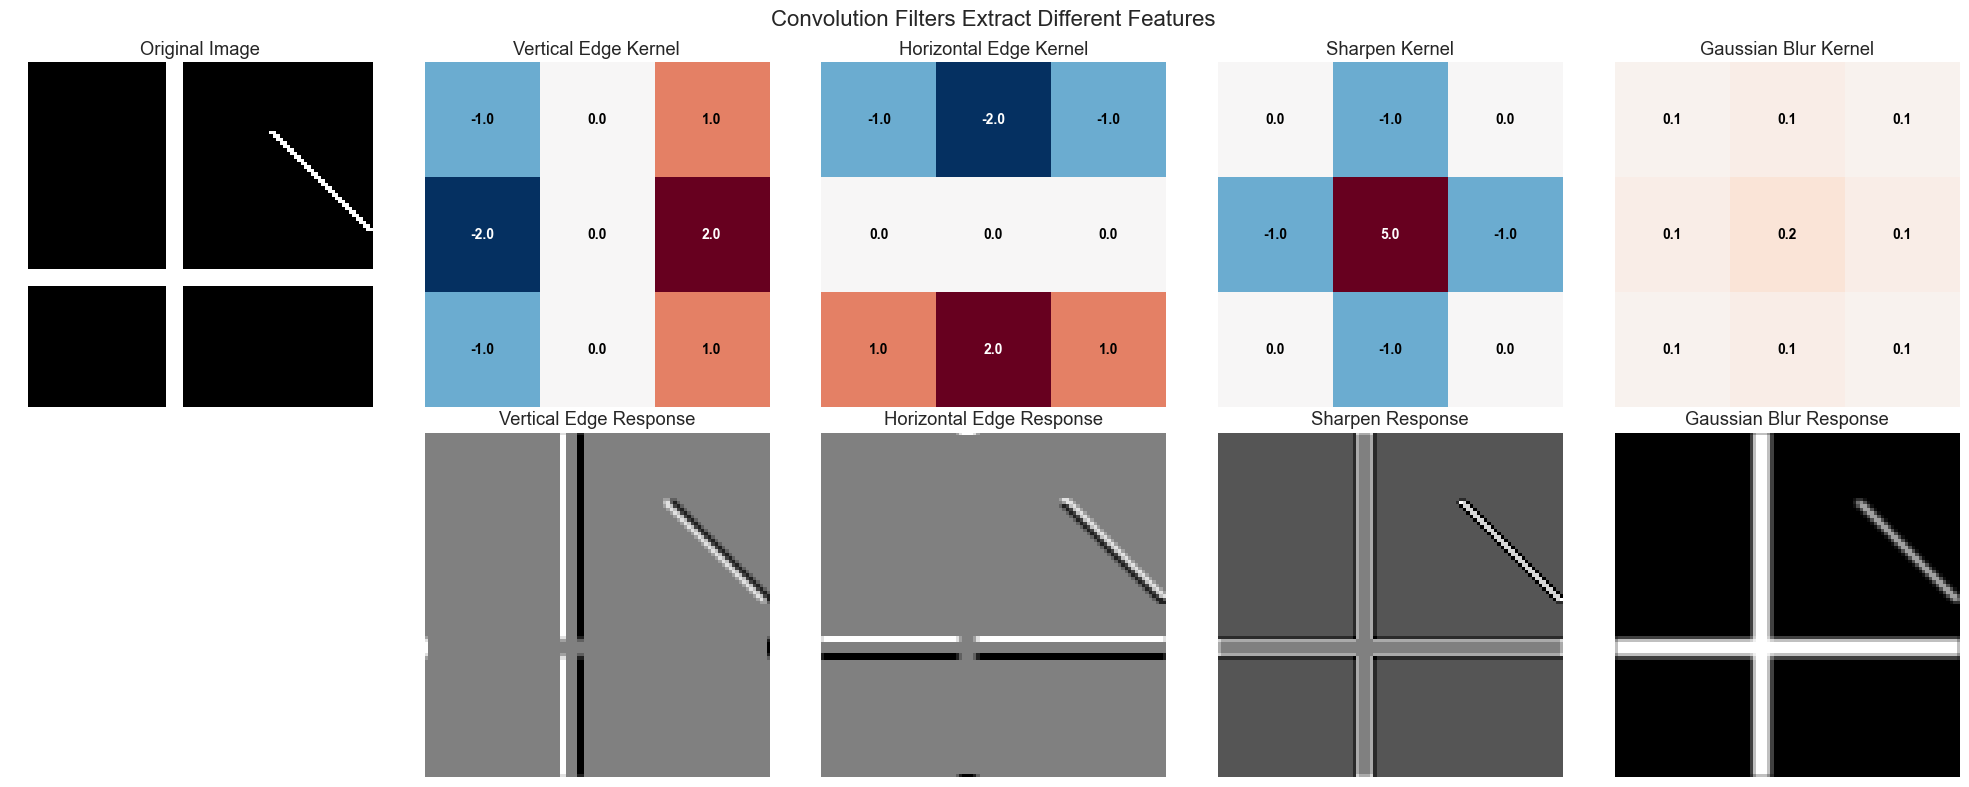

In [13]:
# Demonstrate edge detection with hand-crafted kernels
def visualize_convolution_filters():
    """
    Visualize how different kernels extract different features.
    """
    # Create a sample image with various patterns
    image = np.zeros((100, 100))
    # Add vertical edge
    image[:, 40:45] = 1
    # Add horizontal edge
    image[60:65, :] = 1
    # Add diagonal edge (ensure we don't go out of bounds)
    for i in range(29):  # Changed from 30 to 29 to avoid index 100
        image[20+i, 70+i] = 1
        image[20+i, 71+i] = 1
    
    # Define classic kernels
    kernels = {
        'Vertical Edge': np.array([[-1, 0, 1],
                                   [-2, 0, 2],
                                   [-1, 0, 1]]),
        'Horizontal Edge': np.array([[-1, -2, -1],
                                     [0, 0, 0],
                                     [1, 2, 1]]),
        'Sharpen': np.array([[0, -1, 0],
                            [-1, 5, -1],
                            [0, -1, 0]]),
        'Gaussian Blur': np.array([[1, 2, 1],
                                   [2, 4, 2],
                                   [1, 2, 1]]) / 16
    }
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Original image
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    # Apply each kernel
    for idx, (name, kernel) in enumerate(kernels.items(), 1):
        # Apply convolution
        feature_map = conv2d_naive(image, kernel, padding=1)
        
        # Show kernel with blue-red diverging colormap
        im = axes[0, idx].imshow(kernel, cmap='RdBu_r', vmin=-2, vmax=2)
        axes[0, idx].set_title(f'{name} Kernel')
        axes[0, idx].axis('off')
        
        # Add numerical values to each cell in the kernel
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                value = kernel[i, j]
                # Choose text color based on background intensity
                text_color = 'white' if abs(value) > 1 else 'black'
                axes[0, idx].text(j, i, f'{value:.1f}', 
                                ha='center', va='center', 
                                color=text_color, fontsize=10, fontweight='bold')
        
        # Show feature map
        axes[1, idx].imshow(feature_map, cmap='gray')
        axes[1, idx].set_title(f'{name} Response')
        axes[1, idx].axis('off')
    
    plt.suptitle('Convolution Filters Extract Different Features', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_convolution_filters()

### Key Properties of Convolution

The convolution operation has several mathematical properties that make it perfect for vision:

1. **[Translation Equivariance](https://en.wikipedia.org/wiki/Equivariant_map)**: If you shift the input, the output shifts by the same amount: $f(T(x)) = T(f(x))$
2. **Compositionality**: Multiple convolutions can be composed to create larger [receptive fields](https://en.wikipedia.org/wiki/Receptive_field)
3. **Parameter Efficiency**: A 3×3 kernel has only 9 parameters regardless of image size

The feature maps above show how different kernels act as different feature detectors. In CNNs, these kernels are learned from data rather than hand-crafted, similar to [Gabor filters](https://en.wikipedia.org/wiki/Gabor_filter) in the visual cortex.

## Section 4: Building Hierarchical Features

The true power of CNNs emerges from stacking convolutional layers. Early layers learn simple patterns (edges, corners), while deeper layers combine these into complex features (textures, parts, objects). This hierarchical learning mirrors the [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex), where neurons in [V1](https://en.wikipedia.org/wiki/Visual_cortex#V1) respond to edges while higher areas respond to faces or objects.

### ResNet50 Architecture Overview

We'll visualize features from a [ResNet50](https://arxiv.org/abs/1512.03385) model, which has **50 layers** organized as follows:

- **conv1**: Initial 7×7 convolutional layer (1 layer)
- **layer1**: 3 bottleneck blocks (early features - edges, gradients)
- **layer2**: 4 bottleneck blocks (middle features - textures, patterns)
- **layer3**: 6 bottleneck blocks (deep features - object parts)
- **layer4**: 3 bottleneck blocks (very deep features - semantic concepts)
- **FC layer**: Final fully-connected classifier (1 layer)

Each **bottleneck block** uses three convolutions (1×1 → 3×3 → 1×1) with a skip connection that adds the input directly to the output, allowing gradients to flow more easily during training.

**Architecture Reference**: See Table 1 in the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) (page 4) for the complete layer-by-layer breakdown comparing ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152.

**Key insight**: The visualization below will show features from 5 different depths:
- `conv1` (layer 1) → `layer1` (early) → `layer2` (middle) → `layer3` (deep) → `layer4` (very deep)

In [14]:
def extract_and_visualize_features(model, image_tensor, layer_names=None):
    """
    Extract and visualize features from different depths of ResNet50.
    
    Args:
        model: ResNet50 model
        image_tensor: Input image tensor
        layer_names: List of layer names to visualize (if None, uses default layers)
    """
    if layer_names is None:
        # Select specific convolutional layers from ResNet50
        layer_names = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']
    
    activations = []
    
    # Register hooks to capture activations
    def get_activation(name):
        def hook(model, input, output):
            activations.append((name, output.detach()))
        return hook
    
    # Attach hooks to named layers
    hooks = []
    for name, module in model.named_modules():
        if name in layer_names:
            hook = module.register_forward_hook(get_activation(name))
            hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        _ = model(image_tensor)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Visualize activations
    fig = plt.figure(figsize=(20, 12))
    
    plot_idx = 0
    for name, activation in activations:
        # Skip if not a 4D tensor (batch, channels, height, width)
        if len(activation.shape) != 4:
            print(f"Skipping {name} - shape {activation.shape} is not 4D")
            continue
        
        batch, channels, height, width = activation.shape
        
        # Select subset of channels to visualize (max 16)
        n_channels = min(16, channels)
        
        # Create subplot
        plot_idx += 1
        ax = plt.subplot(len(layer_names), 1, plot_idx)
        
        # Create grid of feature maps
        grid = []
        for c in range(n_channels):
            feature_map = activation[0, c].cpu().numpy()
            # Normalize for visualization
            feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-8)
            grid.append(feature_map)
        
        # Arrange in grid
        n_cols = 8
        n_rows = (n_channels + n_cols - 1) // n_cols
        grid_array = np.zeros((n_rows * height, n_cols * width))
        
        for i in range(n_channels):
            row = i // n_cols
            col = i % n_cols
            grid_array[row*height:(row+1)*height, col*width:(col+1)*width] = grid[i]
        
        ax.imshow(grid_array, cmap='viridis')
        ax.set_title(f'{name} - Shape: {list(activation.shape)} - Showing {n_channels}/{channels} channels')
        ax.axis('off')
    
    plt.suptitle('Hierarchical Feature Learning in ResNet50', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return activations

Extracting features from different network depths...
Watch how features evolve from edges to semantic concepts:



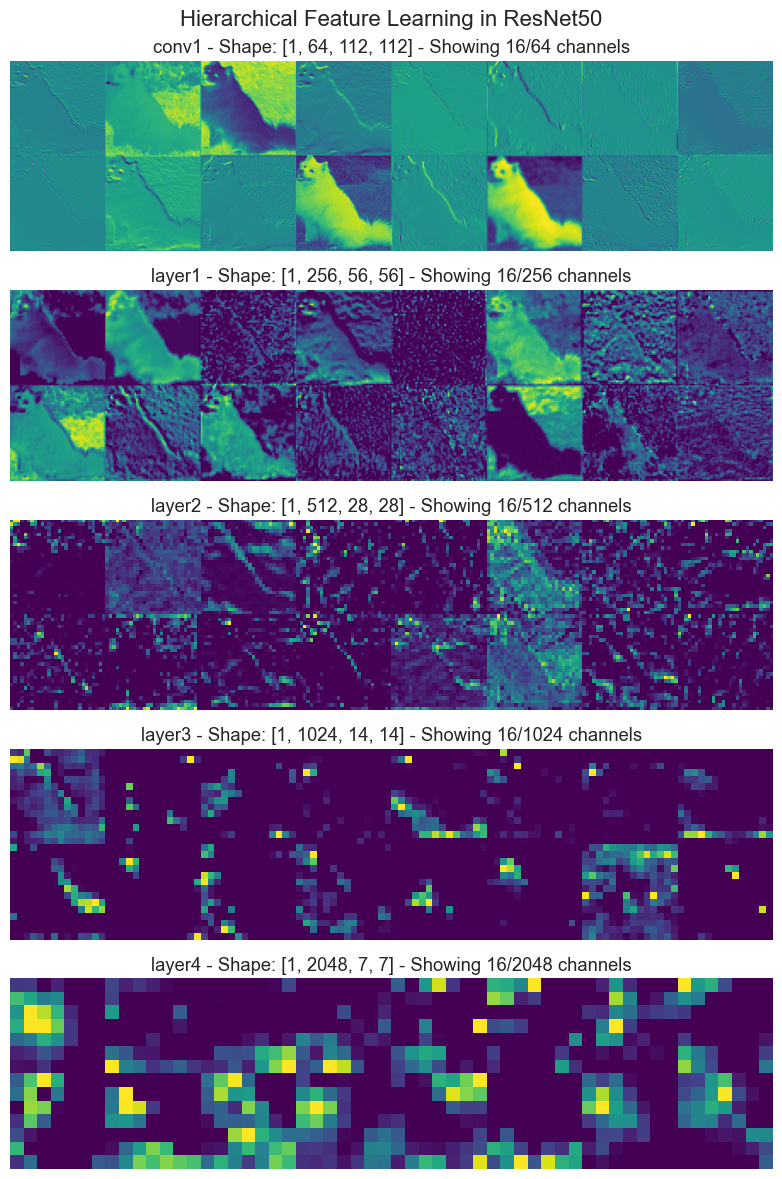

In [15]:
# Load and preprocess a complex image
image_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(image_url, headers={'User-Agent': 'Mozilla/5.0'})
response.raise_for_status()
img = Image.open(BytesIO(response.content)).convert('RGB')
img_tensor = preprocess(img).unsqueeze(0)

# Visualize features at different depths
print("Extracting features from different network depths...")
print("Watch how features evolve from edges to semantic concepts:\n")
activations = extract_and_visualize_features(model, img_tensor)

### Hierarchical Representation Learning

The visualization reveals the hierarchy of learned features:

- **Early layers** (Layer 0): Detect edges and gradients in various orientations. These are similar to [Gabor filters](https://en.wikipedia.org/wiki/Gabor_filter) found in the primary visual cortex.
- **Middle layers** (Layers 4-16): Combine edges into textures, corners, and simple shapes. You can see patterns like fur texture or circular shapes.
- **Deep layers** (Layers 23+): Represent high-level semantic features. Individual feature maps might respond to "dog face," "fur," or "eyes."

This hierarchy emerges naturally through [backpropagation](https://en.wikipedia.org/wiki/Backpropagation). The network learns whatever features help minimize the loss, and it turns out that hierarchical features are optimal for vision tasks.

## Section 5: Building Your Own CNN for MNIST

Now let's build a small CNN from scratch to see how these components work together. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), which contains 70,000 28×28 grayscale images of handwritten digits (0-9).

In [70]:
class TinyCNN(nn.Module):
    """
    A minimal CNN for MNIST classification.
    Architecture: Conv -> ReLU -> Pool -> Conv -> ReLU -> Pool -> FC -> FC
    """
    def __init__(self, num_classes=10):
        super(TinyCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(
            in_channels=1,      # Grayscale input
            out_channels=32,    # 32 feature maps
            kernel_size=3,      # 3x3 kernel
            padding=1          # Preserve spatial dimensions
        )
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # After 2 pooling layers: 28x28 -> 14x14 -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # First block: 28x28x1 -> 14x14x32
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Second block: 14x14x32 -> 7x7x64
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Flatten for FC layers
        x = x.view(x.size(0), -1)
        
        # Classification head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def count_parameters(self):
        """Count total trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [71]:
# Initialize model and compare with MLP
model_cnn = TinyCNN()
print(f"TinyCNN Architecture:\n{model_cnn}")
print(f"\nTotal parameters: {model_cnn.count_parameters():,}")

# Compare with SimpleMLP
mlp_params = 784 * 128 + 128 * 10  # Input -> Hidden -> Output
print(f"\nSimpleMLP parameters: {mlp_params:,}")
print(f"TinyCNN parameters: {model_cnn.count_parameters():,}")
print(f"CNN has {model_cnn.count_parameters() / mlp_params:.2f}x more parameters")

TinyCNN Architecture:
TinyCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 421,834

SimpleMLP parameters: 101,632
TinyCNN parameters: 421,834
CNN has 4.15x more parameters


In [72]:
def visualize_learned_filters(model, layer_name='conv1'):
    """
    Visualize the learned convolutional filters for MNIST (grayscale).
    Uses grayscale colormap: black=negative weights, white=positive weights.
    """
    # Get the convolutional layer
    conv_layer = getattr(model, layer_name)
    
    # Extract weights: (out_channels, in_channels, height, width)
    weights = conv_layer.weight.data.cpu()
    n_filters = weights.shape[0]
    
    # Find global min/max for consistent scaling
    vmin = weights.min().item()
    vmax = weights.max().item()
    # Make symmetric around zero
    vabs = max(abs(vmin), abs(vmax))
    
    # Create grid visualization
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(min(32, n_filters)):
        # Display grayscale filter
        im = axes[i].imshow(weights[i, 0], cmap='gray', vmin=-vabs, vmax=vabs)
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i}', fontsize=8)
    
    # Hide unused subplots
    for i in range(min(32, n_filters), 32):
        axes[i].axis('off')
    
    # Add colorbar
    fig.colorbar(im, ax=axes, orientation='horizontal', 
                 fraction=0.046, pad=0.04, label='Weight Value (Black=Negative, White=Positive)')
    
    plt.suptitle(f'Learned Filters in {layer_name} Layer', fontsize=16)
    plt.tight_layout()
    plt.show()

Randomly Initialized Filters (before training):


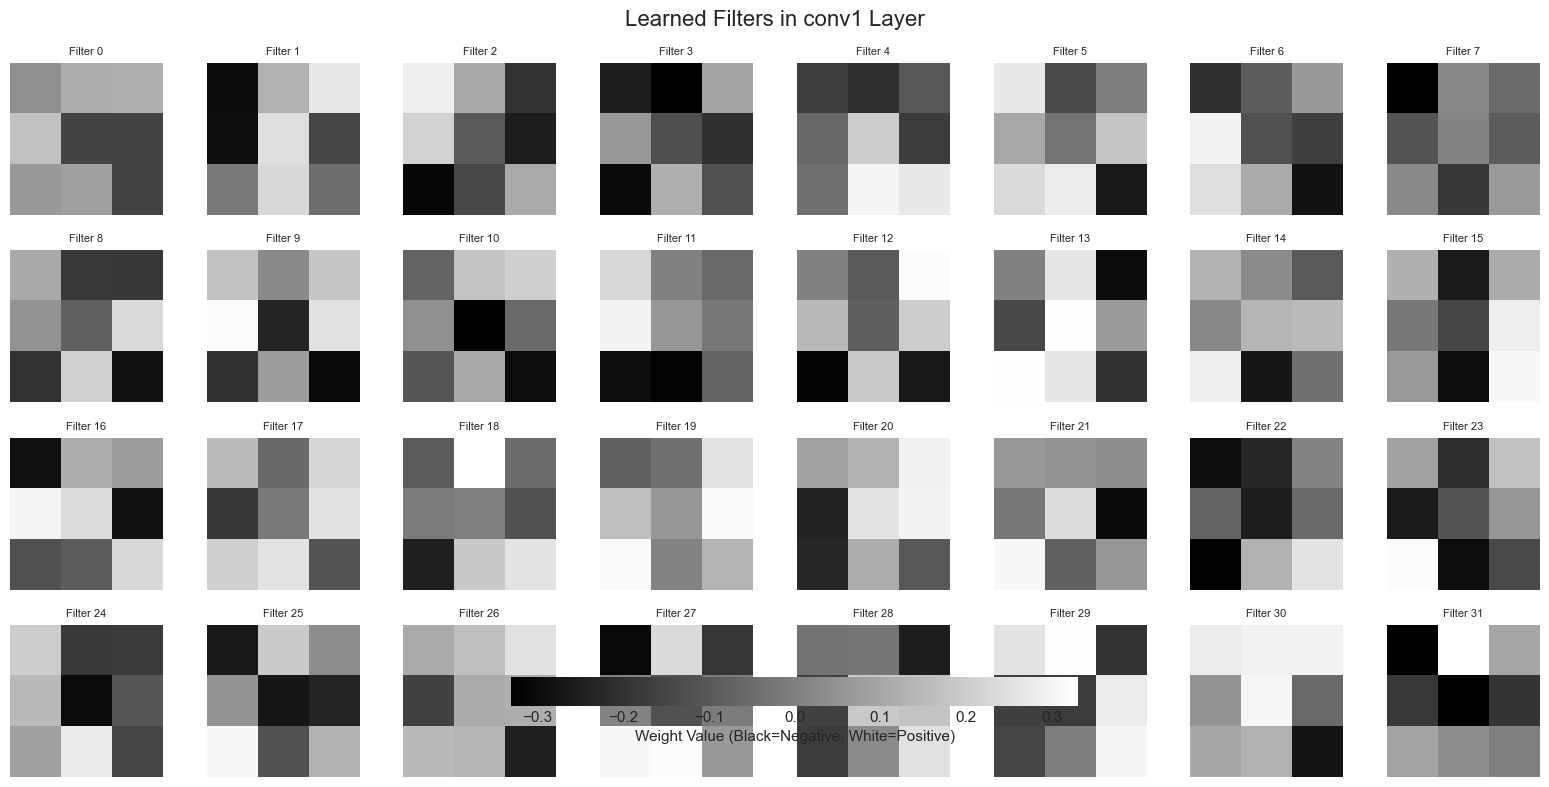

In [73]:
# Visualize randomly initialized filters
print("Randomly Initialized Filters (before training):")
visualize_learned_filters(model_cnn, 'conv1')

In [74]:
# Train TinyCNN on MNIST for direct comparison with SimpleMLP
print("\n" + "="*60)
print("Training TinyCNN on MNIST...")
print("="*60)
model_cnn = TinyCNN()
train_losses_cnn, test_accs_cnn, batch_train_accs_cnn = train_mlp(
    model_cnn, train_loader, test_loader
)


Training TinyCNN on MNIST...
Epoch 1/3, Batch 0/938, Loss: 2.3786, Train Acc: 12.50%
Epoch 1/3, Batch 50/938, Loss: 0.3348, Train Acc: 70.13%
Epoch 1/3, Batch 100/938, Loss: 0.1917, Train Acc: 79.89%
Epoch 1/3, Batch 150/938, Loss: 0.1684, Train Acc: 83.79%
Epoch 1/3, Batch 200/938, Loss: 0.0753, Train Acc: 86.47%
Epoch 1/3, Batch 250/938, Loss: 0.3028, Train Acc: 87.96%
Epoch 1/3, Batch 300/938, Loss: 0.2329, Train Acc: 89.12%
Epoch 1/3, Batch 350/938, Loss: 0.1632, Train Acc: 89.97%
Epoch 1/3, Batch 400/938, Loss: 0.0599, Train Acc: 90.55%
Epoch 1/3, Batch 450/938, Loss: 0.1413, Train Acc: 91.16%
Epoch 1/3, Batch 500/938, Loss: 0.2567, Train Acc: 91.61%
Epoch 1/3, Batch 550/938, Loss: 0.1536, Train Acc: 91.94%
Epoch 1/3, Batch 600/938, Loss: 0.1159, Train Acc: 92.27%
Epoch 1/3, Batch 650/938, Loss: 0.0845, Train Acc: 92.58%
Epoch 1/3, Batch 700/938, Loss: 0.1741, Train Acc: 92.82%
Epoch 1/3, Batch 750/938, Loss: 0.0647, Train Acc: 93.09%
Epoch 1/3, Batch 800/938, Loss: 0.1142, Train

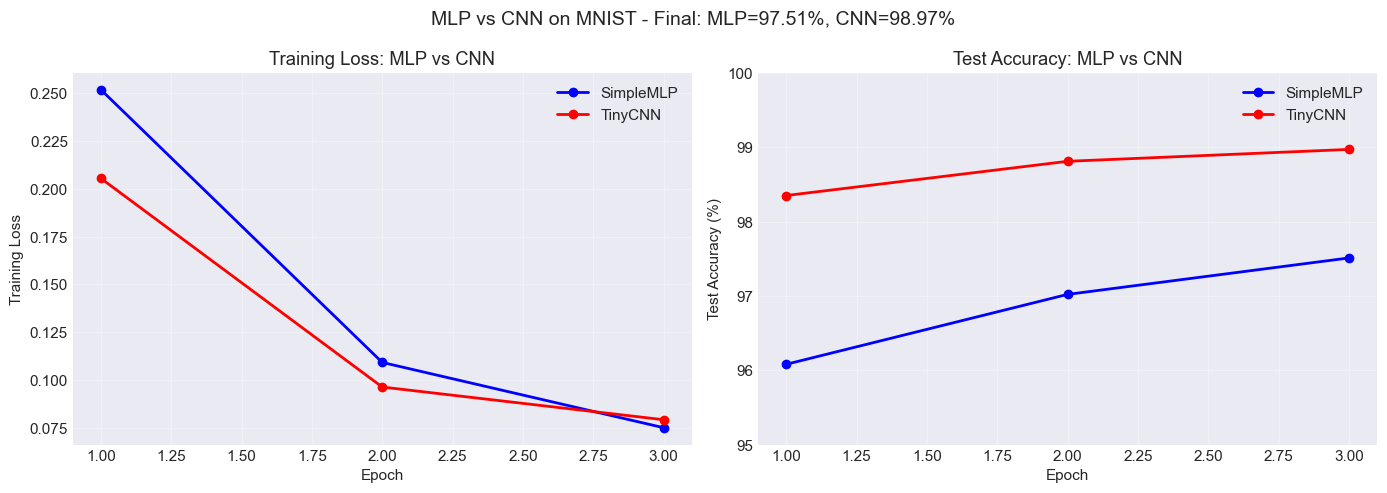


Comparison Results:
SimpleMLP Test Accuracy: 97.51%
TinyCNN Test Accuracy:   98.97%



In [75]:
# Compare MLP vs CNN training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-o', linewidth=2, label='SimpleMLP')
ax1.plot(range(1, len(train_losses_cnn) + 1), train_losses_cnn, 'r-o', linewidth=2, label='TinyCNN')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss: MLP vs CNN')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy comparison
ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, 'b-o', linewidth=2, label='SimpleMLP')
ax2.plot(range(1, len(test_accs_cnn) + 1), test_accs_cnn, 'r-o', linewidth=2, label='TinyCNN')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('Test Accuracy: MLP vs CNN')
ax2.set_ylim([95, 100])
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(f'MLP vs CNN on MNIST - Final: MLP={test_accuracies[-1]:.2f}%, CNN={test_accs_cnn[-1]:.2f}%', 
             fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Comparison Results:")
print(f"SimpleMLP Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"TinyCNN Test Accuracy:   {test_accs_cnn[-1]:.2f}%")
print(f"{'='*60}\n")

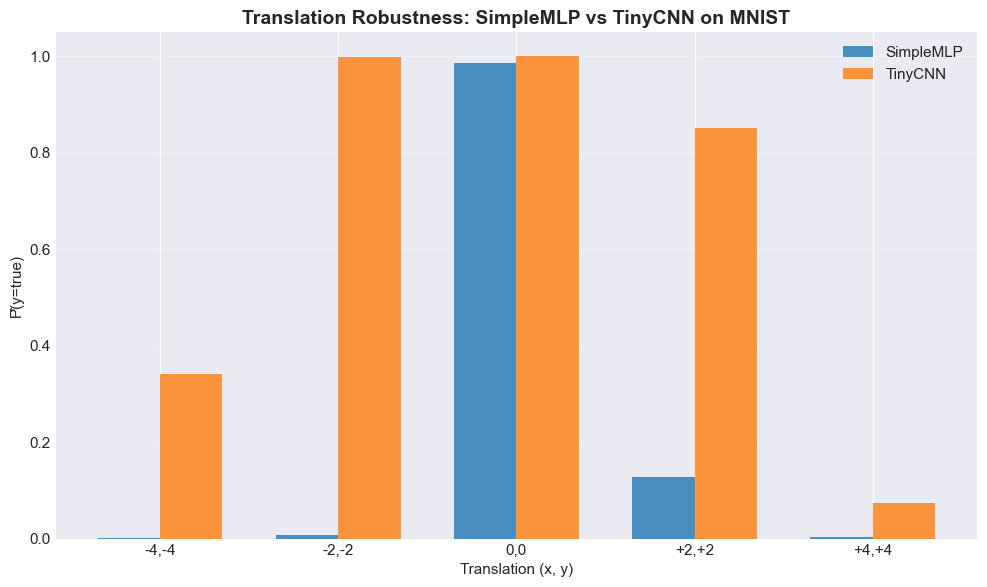

In [86]:
# Direct comparison of translation robustness
shifts_labels = ['-4,-4', '-2,-2', '0,0', '+2,+2', '+4,+4']

# Side-by-side bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(5)
width = 0.35
ax.bar(x - width/2, confidences, width, label='SimpleMLP', alpha=0.8)
ax.bar(x + width/2, confidences_cnn, width, label='TinyCNN', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(shifts_labels)
ax.set_xlabel('Translation (x, y)')
ax.set_ylabel('P̂(y=true)')
ax.set_title('Translation Robustness: SimpleMLP vs TinyCNN on MNIST', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Section 6: Understanding What CNNs Really See

Let's peek inside the "black box" using gradient-based visualization techniques to understand what patterns activate specific neurons. We'll use [saliency maps](https://arxiv.org/abs/1312.6034).

In [80]:
def compute_saliency_map(model, image_tensor, target_class):
    """
    Compute saliency map showing which pixels most influence the prediction.
    
    Uses the gradient of the class score with respect to input pixels.
    """
    model.eval()
    image_tensor.requires_grad = True
    
    # Forward pass
    output = model(image_tensor)
    
    # Zero gradients
    model.zero_grad()
    
    # Backward pass from target class
    output[0, target_class].backward()
    
    # Get gradients with respect to input
    saliency = image_tensor.grad.data.abs()
    
    # Take maximum across color channels
    saliency = saliency.squeeze().max(dim=0)[0]
    
    return saliency.cpu().numpy()

In [81]:
# Load a real image for attribution analysis
# Using a reliable test image
test_image_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(test_image_url, headers={'User-Agent': 'Mozilla/5.0'})
response.raise_for_status()
test_img = Image.open(BytesIO(response.content)).convert('RGB')
test_tensor = preprocess(test_img).unsqueeze(0)

# Get model prediction
model.eval()
with torch.no_grad():
    output = model(test_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = imagenet_classes[predicted_class]

# Compute saliency map
print(f"Computing saliency map for prediction: {predicted_label}")
saliency = compute_saliency_map(model, test_tensor.clone(), predicted_class)

Computing saliency map for prediction: Samoyed


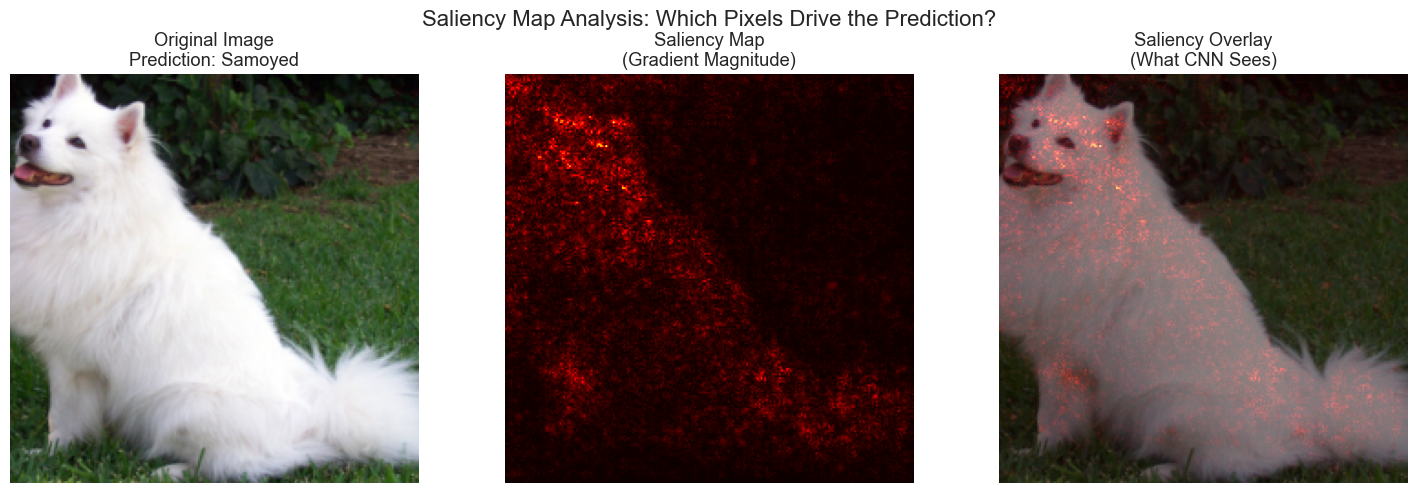

In [82]:
# Visualize saliency map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
img_numpy = test_tensor.squeeze().permute(1, 2, 0).numpy()
img_numpy = img_numpy * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_numpy = np.clip(img_numpy, 0, 1)

axes[0].imshow(img_numpy)
axes[0].set_title(f'Original Image\nPrediction: {predicted_label}')
axes[0].axis('off')

# Saliency map
axes[1].imshow(saliency, cmap='hot')
axes[1].set_title('Saliency Map\n(Gradient Magnitude)')
axes[1].axis('off')

# Overlay
axes[2].imshow(img_numpy)
axes[2].imshow(saliency, cmap='hot', alpha=0.5)
axes[2].set_title('Saliency Overlay\n(What CNN Sees)')
axes[2].axis('off')

plt.suptitle('Saliency Map Analysis: Which Pixels Drive the Prediction?', fontsize=16)
plt.tight_layout()
plt.show()

### Interpreting CNN Decisions with Saliency Maps

[Saliency maps](https://arxiv.org/abs/1312.6034) reveal which pixels most influence the CNN's prediction by computing the gradient of the output class score with respect to input pixels. The brighter regions indicate pixels that, when changed, would most affect the prediction.

**Key Observations:**
- **Semantically meaningful focus**: CNNs typically highlight object-relevant features (e.g., for a dog: face, ears, body outline)
- **Edge detection**: High saliency often appears along object boundaries and distinctive features
- **Background suppression**: Lower attribution on irrelevant background pixels

**Practical Applications:**
- **Debugging failures**: If saliency highlights wrong regions (e.g., background watermarks), the model may be learning [spurious correlations](https://arxiv.org/abs/1807.06732)
- **Model validation**: Ensures the network focuses on appropriate features rather than dataset artifacts
- **Trust and interpretability**: Helps users understand and trust model decisions in critical applications

**Limitations**: Saliency maps can be noisy and may not always reflect the true reasoning process. They show *local sensitivity* (what happens with small changes) rather than complete feature importance.

## Conclusion

We've explored CNNs from first principles to practical applications. The key takeaways:

- **Convolution enables weight sharing**: The same feature detector works everywhere in the image, reducing parameters from millions to thousands
- **Hierarchical learning mirrors vision**: Early layers detect edges, later layers compose them into objects, similar to the [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex)
- **Pooling creates invariance**: Small translations don't affect predictions, making CNNs robust to minor variations
- **Transfer learning is powerful**: Features learned on [ImageNet](https://www.image-net.org/) transfer to most visual tasks, enabling training with limited data
- **CNNs learn meaningful features**: Attribution analysis shows networks focus on semantically relevant patterns, not arbitrary correlations

Modern CNNs achieve superhuman performance on many vision tasks, but they're not magic. They're composed of simple operations (convolution, pooling, non-linearity) arranged in clever architectures. Understanding these fundamentals empowers you to diagnose failures, adapt architectures, and push the boundaries of computer vision.